ドライブのマウント

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!mkdir /content/data

データの読み込み(修正しないように!!)

In [3]:
import os
import numpy as np
from torchvision import datasets, transforms
mnist_train = datasets.MNIST(
    root='/content/data/',
    download=True,
    train=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)
mnist_test = datasets.MNIST(
    root='/content/data/',
    download=True,
    train=False,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 58188131.99it/s]


Extracting /content/data/MNIST/raw/train-images-idx3-ubyte.gz to /content/data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1733109.58it/s]


Extracting /content/data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 13699826.07it/s]


Extracting /content/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5676558.04it/s]

Extracting /content/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/data/MNIST/raw



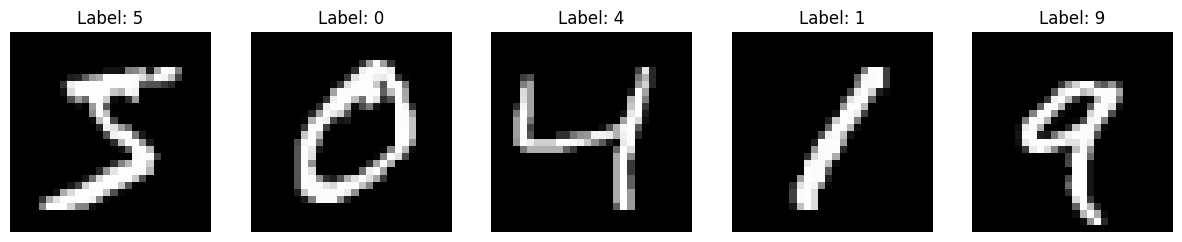

In [4]:
import matplotlib.pyplot as plt

# データの中身を確認する関数
def show_mnist_data(dataset, num_samples=None):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        image, label = dataset[i]
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    plt.show()

# 訓練データの先頭5件を確認
show_mnist_data(mnist_train, num_samples=5)

## 練習課題
1. モデル のseed 値・ハイパーパラメータを自分で設定して、実際にモデルの訓練・推論を行ってみよう。seed値・ハイパーパラメータを変更するとモデルの性能は変わるだろうか?
2. モデル のアーキテクチャを変更して、推論精度を向上させてみよう。

 Hint: sigmoid 関数以外の活性化関数にはどのようなものがあるだろうか？
中間層を追加すると、モデルの推論性能・学習にかかる時間はどのように変化するだろうか？


In [6]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import inspect

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 学習データ
x_train = mnist_train.train_data.numpy()
t_train = mnist_train.train_labels.numpy()
# テストデータ
x_test = mnist_test.test_data.numpy()
t_test = mnist_test.test_labels.numpy()

class train_dataset(torch.utils.data.Dataset):
    def __init__(self, x_train, t_train):
        self.x_train = x_train.reshape(-1, 784).astype('float32') / 255 # MNIST は28*28=784ピクセルのデータ
        self.t_train = t_train

    def __len__(self):
        return self.x_train.shape[0]

    def __getitem__(self, idx):
        return torch.tensor(self.x_train[idx], dtype=torch.float), torch.tensor(self.t_train[idx], dtype=torch.long)

class test_dataset(torch.utils.data.Dataset):
    def __init__(self, x_test):
        self.x_test = x_test.reshape(-1, 784).astype('float32') / 255

    def __len__(self):
        return self.x_test.shape[0]

    def __getitem__(self, idx):
        return torch.tensor(self.x_test[idx], dtype=torch.float)

trainval_data = train_dataset(x_train, t_train)
test_data = test_dataset(x_test)

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


ニューラルネットワークの実装

In [8]:
batch_size = 100

val_size = int(len(trainval_data) * 0.2)
train_size = len(trainval_data) - val_size

train_data, val_data = torch.utils.data.random_split(trainval_data, [train_size, val_size])

dataloader_train = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)

dataloader_valid = torch.utils.data.DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=True
)

dataloader_test = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False
)

In [10]:
# ToDo: sigmoid 関数以外の活性化関数を使ってモデルを作成してみる
# ToDo: ハイパーパラメタを色々変えてみる

def sigmoid(x):
    # 単純な実装
    # return 1 / (1 + torch.exp(-x))

    # expのoverflow対策を施した実装
    # x >=0 のとき sigmoid(x) = 1 / (1 + exp(-x))
    # x < 0 のとき sigmoid(x) = exp(x) / (1 + exp(x))
    return torch.exp(torch.minimum(x, torch.tensor(0.0))) / (1 + torch.exp(- torch.abs(x)))

def softmax(x):
    x_exp = torch.exp(x - x.max(dim=1, keepdim=True).values)
    return x_exp / x_exp.sum(dim=1, keepdim=True)

class Dense(nn.Module):  # nn.Moduleを継承
    def __init__(self, in_dim, out_dim, function=lambda x: x):
        super(Dense, self).__init__()
        # Xavier初期化
        self.W = nn.Parameter(torch.randn(in_dim, out_dim) * np.sqrt(2. / (in_dim + out_dim)))
        self.b = nn.Parameter(torch.zeros(out_dim))
        self.function = function

    def forward(self, x):
        return self.function(torch.matmul(x, self.W) + self.b)

class MLP(nn.Module):  # nn.Moduleを継承
    def __init__(self, in_dim, hid_dim1, hid_dim2, out_dim):
        super(MLP, self).__init__()
        self.linear1 = Dense(in_dim, hid_dim1, function=sigmoid)
        self.linear2 = Dense(hid_dim1, hid_dim2, function=sigmoid)
        self.linear3 = Dense(hid_dim2, out_dim, function=softmax)

    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        return x

# ハイパーパラメータの設定
in_dim = 784 # 28*28
hid_dim1 = 28
hid_dim2 = 28
out_dim = 10 # 0~9
lr = 0.01
n_epochs = 3  # エポック数

# モデルのインスタンス化
mlp = MLP(in_dim, hid_dim1, hid_dim2, out_dim).to(device)

optimizer = optim.Adam(mlp.parameters(), lr=lr)

In [11]:
for epoch in range(n_epochs):
    losses_train = []
    losses_valid = []
    train_num = 0
    train_true_num = 0
    valid_num = 0
    valid_true_num = 0

    mlp.train()  # 訓練時には勾配を計算するtrainモードにする
    for x, t in dataloader_train:
        x, t = x.to(device), t.to(device)
        optimizer.zero_grad()  # 勾配を0で初期化
        pred = mlp(x)  # モデルで予測
        loss = nn.CrossEntropyLoss()(pred, t)  # 損失を計算
        loss.backward()  # 勾配を計算
        optimizer.step()  # パラメータを更新

        losses_train.append(loss.item())

        # あとでまとめてacc計算
        acc = torch.where(t == pred.argmax(1), torch.ones_like(t), torch.zeros_like(t)) #例えば、tが[2, 0, 1]で、pred.argmax(1)が[2, 1, 1]の場合、t == pred.argmax(1)は[True, False, True]
        train_num += t.size(0)
        train_true_num += acc.sum().item()

    mlp.eval()  # 評価時には勾配を計算しないevalモードにする
    for x, t in dataloader_valid:
        x, t = x.to(device), t.to(device)
        with torch.no_grad():  # 勾配計算を無効化
            pred = mlp(x)
            loss = nn.CrossEntropyLoss()(pred, t)

        losses_valid.append(loss.item())

        acc = torch.where(t == pred.argmax(1), torch.ones_like(t), torch.zeros_like(t))
        valid_num += t.size(0)
        valid_true_num += acc.sum().item()

    print('EPOCH: {}, Train [Loss: {:.3f}, Accuracy: {:.3f}], Valid [Loss: {:.3f}, Accuracy: {:.3f}]'.format(
        epoch,
        np.mean(losses_train),
        train_true_num/train_num,
        np.mean(losses_valid),
        valid_true_num/valid_num
    ))

EPOCH: 0, Train [Loss: 1.719, Accuracy: 0.762], Valid [Loss: 1.559, Accuracy: 0.911]
EPOCH: 1, Train [Loss: 1.538, Accuracy: 0.929], Valid [Loss: 1.534, Accuracy: 0.931]
EPOCH: 2, Train [Loss: 1.523, Accuracy: 0.941], Valid [Loss: 1.527, Accuracy: 0.937]


テストデータに対する推論

In [12]:
!mkdir /content/results

In [13]:
mlp.eval()

t_pred = []
for x in dataloader_test:
    x = x.to(device)
    # 順伝播
    y = mlp.forward(x)
    # モデルの出力を予測値のスカラーに変換
    pred = y.argmax(1).tolist()
    t_pred.extend(pred)

# 予測精度の計算
t_test_tensor = torch.tensor(t_test, dtype=torch.long).to(device)
t_pred_tensor = torch.tensor(t_pred, dtype=torch.long).to(device)
accuracy = (t_test_tensor == t_pred_tensor).sum().item() / len(t_test_tensor)

# true_label と predicted_label を保存
true_label = t_test_tensor.cpu().numpy()
predicted_label = t_pred_tensor.cpu().numpy()

# CSVファイルに保存
submission_df = pd.DataFrame({
    'true_label': true_label,
    'predicted_label': predicted_label
})
submission_df.to_csv('/content/results/results_pred.csv', index_label='id')

print(f'Test Accuracy: {accuracy:.3f}')

Test Accuracy: 0.938
